# Map 2D data

This notebook describes an algorithm for how to map 2D data using the (george package), which is based on Gaussian Process Regression  
[https://george.readthedocs.io/en/latest/]. 

Gaussian Processes (GP) are a supervised learning method designed to solve regression and probabilistic classification problems.

An introduction to GP regression can be found here: https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb




To test the function we choose to use temperature data from Argo floats similar to Kuessler and Stein (2018)  
https://doi.org/10.1098/rspa.2018.0400


The function will perform the following steps 
    
* Load a subset of Argo data using argopy
* Linearly interpolate onto pressure levels and select one pressure level for use
* Compute the mean state
* Subtract the mean state from the data to get the anomalies
* The GP is applied to the anomaly data



In [1]:
%matplotlib inline
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':14})

In [2]:
# Define region of interest to interpolate

ilat = 40
flat = 60
ilon = -50
flon = -30
idepth = 100
fdepth = 300
idate = "2010-01-01"
fdate = "2012-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [3]:
argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([250]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

In [4]:
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 4365, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 46.99 57.87 41.68 ... 59.53 47.54 56.85
    LONGITUDE          (N_PROF) float64 -33.56 -43.03 -48.08 ... -42.57 -43.84
    TIME               (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-1...
  * N_PROF             (N_PROF) int64 1674 1467 790 1437 ... 1031 2455 2885 2711
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 13.181076 ... 3.96...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-50.00/-30.00; y=40.00/60.00; z=100.0/300.0;...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [5]:
import pandas as pd

# The lon,lat,time coordinates need to be in a specific format for george

Input_coordinates=xr.concat((selected_vars.LONGITUDE,selected_vars.LATITUDE,selected_vars.TIME.dt.dayofyear),pd.Index(['lon','lat','time'], name="coordinate")).T

In [6]:
Input_coordinates

<xarray.DataArray 'LONGITUDE' (N_PROF: 4365, coordinate: 3)>
array([[-33.55699921,  46.99200058,   1.        ],
       [-43.03499985,  57.87200165,   1.        ],
       [-48.07699585,  41.67699814,   1.        ],
       ...,
       [-36.235     ,  59.527     , 365.        ],
       [-42.566     ,  47.536     , 365.        ],
       [-43.836     ,  56.852     , 365.        ]])
Coordinates:
    TIME        (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-12-31T19...
    LONGITUDE   (N_PROF) float64 -33.56 -43.03 -48.08 ... -36.24 -42.57 -43.84
    LATITUDE    (N_PROF) float64 46.99 57.87 41.68 54.15 ... 59.53 47.54 56.85
  * N_PROF      (N_PROF) int64 1674 1467 790 1437 897 ... 74 1031 2455 2885 2711
  * coordinate  (coordinate) object 'lon' 'lat' 'time'

In [7]:
Input_coordinates[:,2]

<xarray.DataArray 'LONGITUDE' (N_PROF: 4365)>
array([  1.,   1.,   1., ..., 365., 365., 365.])
Coordinates:
    TIME        (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-12-31T19...
    LONGITUDE   (N_PROF) float64 -33.56 -43.03 -48.08 ... -36.24 -42.57 -43.84
    LATITUDE    (N_PROF) float64 46.99 57.87 41.68 54.15 ... 59.53 47.54 56.85
  * N_PROF      (N_PROF) int64 1674 1467 790 1437 897 ... 74 1031 2455 2885 2711
    coordinate  <U4 'time'

In [10]:
import george as grg
import numpy as np

Choose a kernel (covariance) function to model these data, assume a zero mean model

In [12]:
# Define lengthscale

Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

#test larger length scales
Lxscale = 180e3*np.sin(2*np.pi/360*50)
Lyscale = 180e3

# Define kernel (covariance function)
# A simple exponential squared kernel is used, assuming isentropy. 
# There are a number of kernels that can be used. Here we are testing 2:
# 1) the expontential squared kernel: kernel_argo_expsq
# 2) the Matern 3/2 kernel: kernel_argo_matern32

# Since we want to learn anisotropy in the data anomalies, which is not aligned with lon-lat,
# we have to allow for a non-diagonal matrix C in the definition of distance. 
# Let's be our first guess to be a diagonal matrix C, though.

kernel_argo_expsq = grg.kernels.ExpSquaredKernel(
                                            [
                                                [100e3**2/Lxscale**2,0,0],                
                                                [0,100e3**2/Lyscale**2,0], 
                                                [0,0,30**2]
                                            ], ndim=3)
kernel_argo_matern32 = grg.kernels.Matern32Kernel(
                                            [
                                                [100e3**2/Lxscale**2,0,0],                
                                                [0,100e3**2/Lyscale**2,0], 
                                                [0,0,30**2]
                                            ], ndim=3)

In [13]:
# Now let us set up the GP. 

gp_argo_expsq = grg.GP(kernel_argo_expsq)
gp_argo_matern32 = grg.GP(kernel_argo_matern32)

In [32]:
gp_argo_expsq.compute(Input_coordinates_1pt, 0.01) # 0.01 is an estimated observational error/ noise
#gp_argo_matern32.compute(Input_coordinates, 0.01)

ValueError: Dimension mismatch

In [34]:

Input_coordinates_1pt = Input_coordinates[0,:]
shInput_coordinates_1pt

<xarray.DataArray 'LONGITUDE' (coordinate: 3)>
array([-33.55699921,  46.99200058,   1.        ])
Coordinates:
    TIME        datetime64[ns] 2010-01-01T03:48:00
    LONGITUDE   float64 -33.56
    LATITUDE    float64 46.99
    N_PROF      int64 1674
  * coordinate  (coordinate) object 'lon' 'lat' 'time'

In [15]:
# Define some test grid points

#test_pts_argo = np.array(np.meshgrid(np.linspace(ilon,flon,30), 
#                       np.linspace(ilat,flat,30),
#                        np.linspace(0,365,30))).reshape(3,-1).T

test_pts_argo = np.array(np.meshgrid(np.linspace(ilon,flon,30),     #only one time value - speeds up the prediction
                       np.linspace(ilat,flat,30),
                        150.0)).reshape(3,-1).T

test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [16]:
pred_argo_expsq, pred_var_argo_expsq = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_argo_matern32, pred_var_argo_matern32 = gp_argo_matern32.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo_expsq = xr.DataArray(pred_argo_expsq,  dims={"test_pt_num"})
pred_var_argo_expsq = xr.DataArray(pred_var_argo_expsq,  dims={"test_pt_num"})

pred_argo_matern32 = xr.DataArray(pred_argo_matern32,  dims={"test_pt_num"})
pred_var_argo_matern32 = xr.DataArray(pred_var_argo_matern32,  dims={"test_pt_num"})

NameError: name 'Anomaly' is not defined

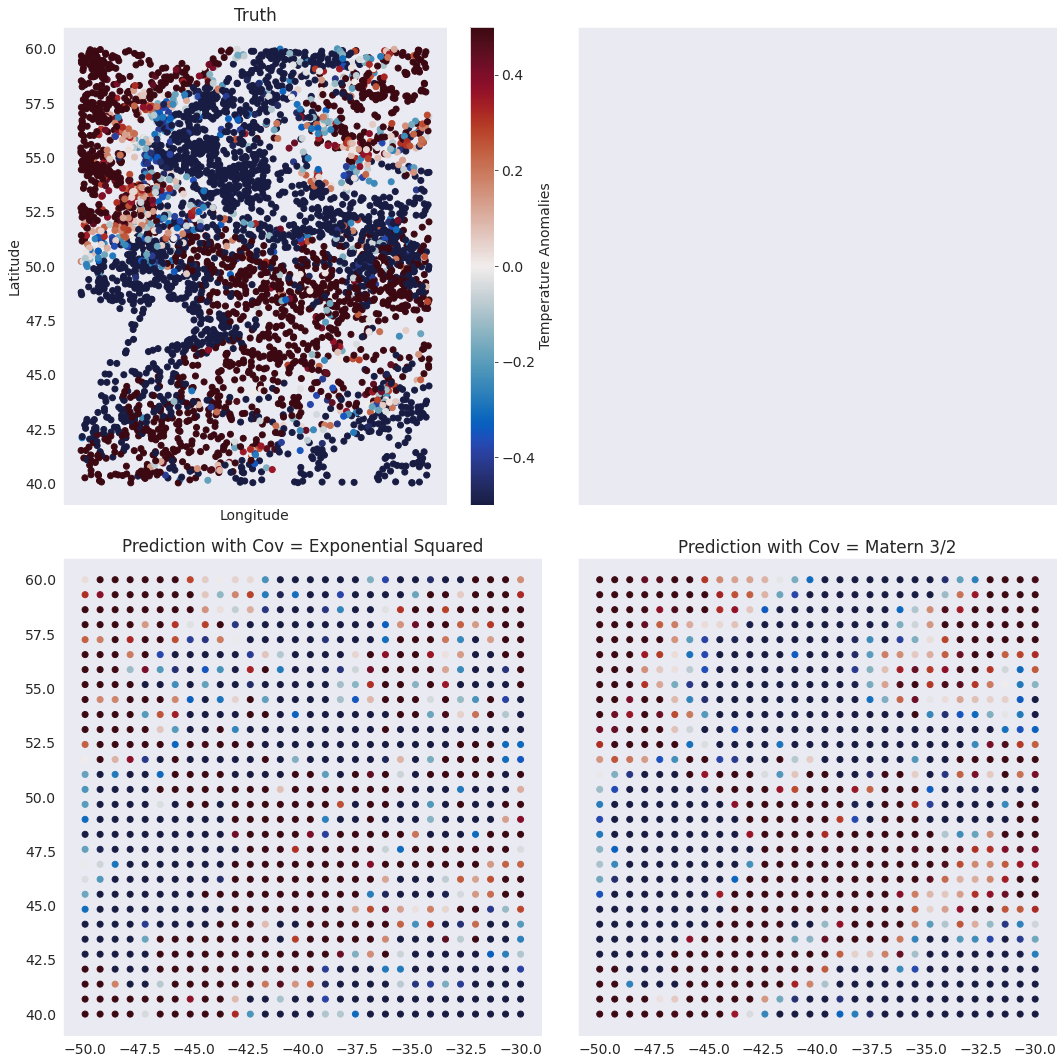

In [43]:
x_sel = Input_coordinates
y_sel = Anomaly

fig,ax=plt.subplots(2,2,figsize=(15,15),sharex=True,sharey=True)

cs=ax[0,0].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)
#ax[0].set_xlim(-50.5,-30.5)
ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_title('Truth')

cs2=ax[1,0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo_expsq, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1,0].set_title('Prediction with Cov = Exponential Squared')

cs3=ax[1,1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo_matern32, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1,1].set_title('Prediction with Cov = Matern 3/2')


cbar=plt.colorbar(cs,ax=ax[0,0])
cbar.set_label('Temperature Anomalies')


plt.tight_layout()

In [44]:
# Compute the Maximum Likelihood

print("Initial ln-likelihood for Cov = Expontential Sqared: {0:.2f}".format(gp_argo_expsq.log_likelihood(Anomaly)))
print("Initial ln-likelihood for Cov = Matern 3/2: {0:.2f}".format(gp_argo_matern32.log_likelihood(Anomaly)))

Initial ln-likelihood for Cov = Expontential Sqared: -42726.43
Initial ln-likelihood for Cov = Matern 3/2: -7751.15


Use Scipys optimize function to fit the maximum likelihood parameters 

In [47]:
from scipy.optimize import minimize


def neg_ln_like_argo_expsq(p):
    gp_argo_expsq.set_parameter_vector(p)
    return -gp_argo_expsq.log_likelihood(Anomaly)

def grad_neg_ln_like_argo_expsq(p):
    gp_argo_expsq.set_parameter_vector(p)
    return -gp_argo_expsq.grad_log_likelihood(Anomaly)

def neg_ln_like_argo_matern32(p):
    gp_argo_matern32.set_parameter_vector(p)
    return -gp_argo_matern32.log_likelihood(Anomaly)

def grad_neg_ln_like_argo_matern32(p):
    gp_argo_matern32.set_parameter_vector(p)
    return -gp_argo_matern32.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [48]:
%time result_argo_expsq = minimize(neg_ln_like_argo_expsq,gp_argo_expsq.get_parameter_vector(), jac=grad_neg_ln_like_argo_expsq)

CPU times: user 24min 22s, sys: 2min 44s, total: 27min 6s
Wall time: 11min 18s


In [49]:
%time result_argo_matern32= minimize(neg_ln_like_argo_matern32,gp_argo_matern32.get_parameter_vector(), jac=grad_neg_ln_like_argo_matern32)


CPU times: user 10min 46s, sys: 1min 41s, total: 12min 27s
Wall time: 6min 22s


In [50]:
# Optimized likelihood

gp_argo_expsq.set_parameter_vector(result_argo_expsq.x)
print("\nFinal ln-likelihood for Cov = Exponential Squared: {0:.2f}".format(gp_argo_expsq.log_likelihood(Anomaly)))

gp_argo_matern32.set_parameter_vector(result_argo_matern32.x)
print("\nFinal ln-likelihood for Cov = Matern 3/2: {0:.2f}".format(gp_argo_matern32.log_likelihood(Anomaly)))



Final ln-likelihood for Cov = Exponential Squared: -8724.60

Final ln-likelihood for Cov = Matern 3/2: -7717.56


In [51]:
# Here the new prediction is made using the MLE parameter estimates

pred_MLE_argo_expsq, pred_var_MLE_argo_expsq = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo_expsq = xr.DataArray(pred_MLE_argo_expsq,  dims={"test_pt_num"})
pred_var_MLE_argo_expsq = xr.DataArray(pred_var_MLE_argo_expsq,  dims={"test_pt_num"})

pred_MLE_argo_matern32, pred_var_MLE_argo_matern32 = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo_matern32 = xr.DataArray(pred_MLE_argo_matern32,  dims={"test_pt_num"})
pred_var_MLE_argo_matern32 = xr.DataArray(pred_var_MLE_argo_matern32,  dims={"test_pt_num"})

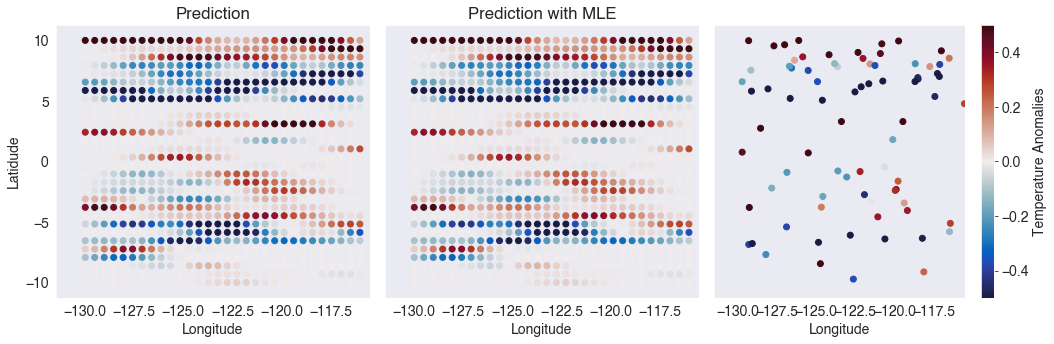

In [66]:
fig,ax= plt.subplots(3,2,figsize=(15,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latidude')
ax[0].set_title('Prediction')

cs2=ax[1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1].set_xlabel('Longitude')
ax[1].set_title('Prediction with MLE')


x_sel = Input_coordinates.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

y_sel = Anomaly.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, cmap='RdBu_r')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')


cs=ax[2].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)

ax[2].set_xlabel('Longitude')
cbar=plt.colorbar(cs,ax=ax[2])
cbar.set_label('Temperature Anomalies')
ax[2].set_label('Truth')
ax[2].set_xlim(-131.5, -115.5)

plt.tight_layout()



In [53]:
# Did the MLE change the length scales that we had guessed?
print('Expontential Squared')
print(gp_argo_expsq.parameter_names)
print(np.exp(gp_argo_expsq.parameter_vector))

print('Matern 3/2')
print(gp_argo_matern32.parameter_names)
print(np.exp(gp_argo_matern32.parameter_vector))

Expontential Squared
('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_L_0_0', 'kernel:k2:metric:L_0_1', 'kernel:k2:metric:L_0_2', 'kernel:k2:metric:log_L_1_1', 'kernel:k2:metric:L_1_2', 'kernel:k2:metric:log_L_2_2')
[1.00000000e+00 1.25000000e-12 1.42413396e+00 9.11448498e-02
 1.00812095e+00 5.55292725e-01 3.77802960e-01 9.98939600e-01
 2.95425434e+01]
Matern 3/2
('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_L_0_0', 'kernel:k2:metric:L_0_1', 'kernel:k2:metric:L_0_2', 'kernel:k2:metric:log_L_1_1', 'kernel:k2:metric:L_1_2', 'kernel:k2:metric:log_L_2_2')
[1.00000000e+00 1.25000000e-12 1.43505964e+00 7.75201257e-01
 1.00379801e+00 5.55783194e-01 6.90181265e-01 9.99315296e-01
 2.98379713e+01]


In [54]:
print('Expontential Squared')
print('Lx(km)='+str((np.exp(gp_argo_expsq.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo_expsq.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo_expsq.parameter_vector[5]))**0.5))

print('Matern 3/2')
print('Lx(km)='+str((np.exp(gp_argo_matern32.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo_matern32.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo_matern32.parameter_vector[5]))**0.5))
# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Expontential Squared
Lx(km)=41.62867025853391
Ly(km)=180.72940744309946
Timescale(km)=0.7451796598365467
Matern 3/2
Lx(km)=121.40419842033236
Ly(km)=180.34149688404048
Timescale(km)=0.7455086813139954
